In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline
import torch.optim as optim

In [2]:
torch.manual_seed(1)

In [3]:
EPOCH = 10
BATCH_SIZE = 32
LR = 0.005
path = '/Users/ruchira/Documents/lvl_4_project/lvl4-hons-project/notebooks'

In [4]:
# X_train = np.loadtxt(path + 'X_train.csv', delimiter=',')
# y_train = np.loadtxt(path + 'y_train.csv', delimiter=',')
# X_test = np.loadtxt(path + 'X_test.csv', delimiter=',')
# y_test = np.loadtxt(path + 'y_test.csv', delimiter=',')

train = np.loadtxt(path + '/train_test_sampled/train.csv', delimiter=',')
test = np.loadtxt(path + '/train_test_sampled/test.csv', delimiter=',')

print(train.shape)
print(test.shape)

(57944, 259)
(54414, 259)


In [5]:
X_train = train[:,:-3]
y_train = train[:,-3]


X_test = test[:,:-3]
y_test = test[:,-3]


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(57944, 256)
(57944,)
(54414, 256)
(54414,)


In [6]:
train_arr = np.hstack((X_train, y_train.reshape(-1,1)))
print(train_arr.shape)

(57944, 257)


In [7]:
tensor_Xtrain = torch.from_numpy(X_train)
tensor_ytrain = torch.from_numpy(y_train)

train_data = Data.TensorDataset(tensor_Xtrain, tensor_ytrain)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
class Encoder(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
    
    def forward(self,x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

class Decoder(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)
    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))
    
class VAE(nn.Module):
    latent_dim = 8

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
#         self.latent_dim = latent_dim
        self._enc_mu = torch.nn.Linear(100, 8)
        self._enc_log_sigma = torch.nn.Linear(100, 8)
    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)


def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)


In [10]:
input_dim = 1 * 256
encoder = Encoder(input_dim, 100, 100)
decoder = Decoder(8, 100, input_dim)
vae = VAE(encoder, decoder)
print(vae)

VAE(
  (encoder): Encoder(
    (linear1): Linear(in_features=256, out_features=100, bias=True)
    (linear2): Linear(in_features=100, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=8, out_features=100, bias=True)
    (linear2): Linear(in_features=100, out_features=256, bias=True)
  )
  (_enc_mu): Linear(in_features=100, out_features=8, bias=True)
  (_enc_log_sigma): Linear(in_features=100, out_features=8, bias=True)
)


In [11]:
view_data = Variable(tensor_Xtrain[:5].view(-1, 256).type(torch.FloatTensor)/255.)


Number of samples:  57944
0 0.8692426085472107


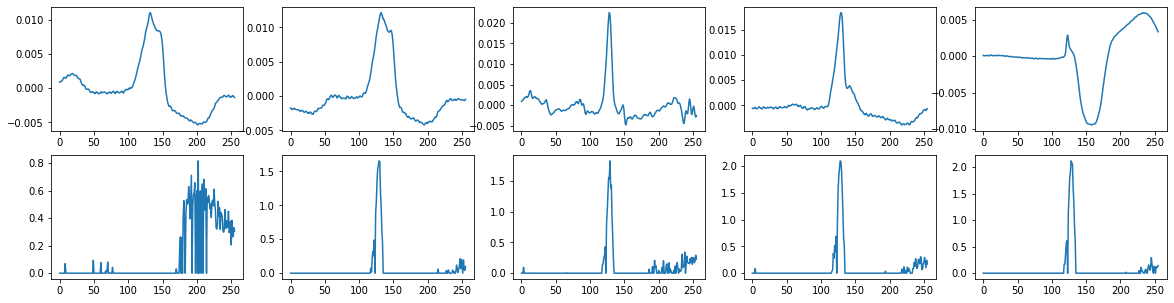

1 0.8497966527938843


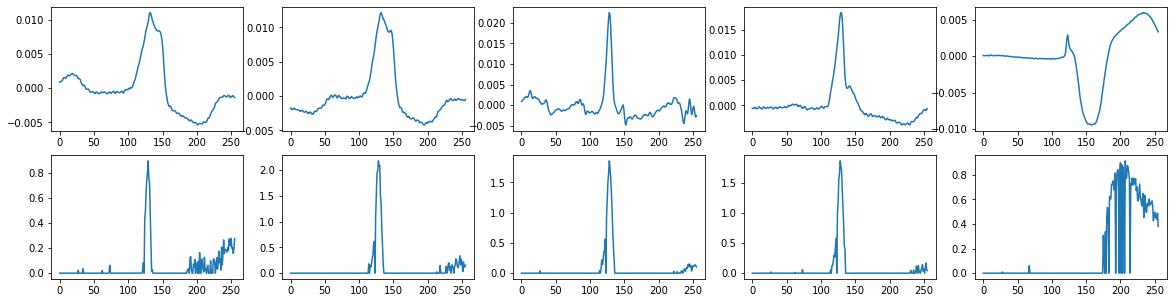

2 0.8519459366798401


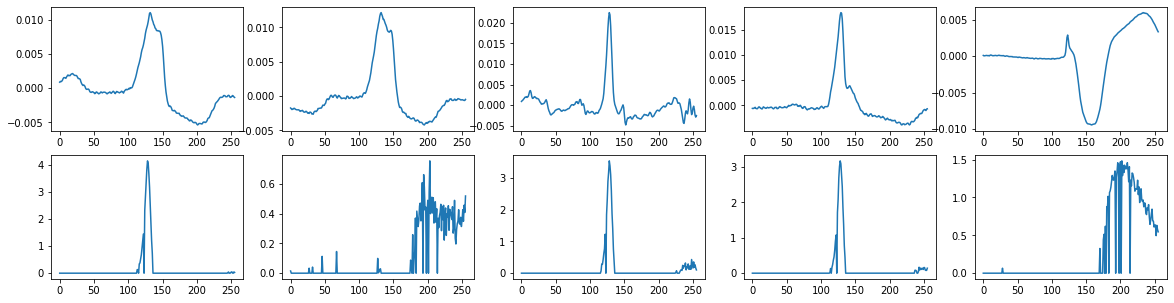

3 0.8844428062438965


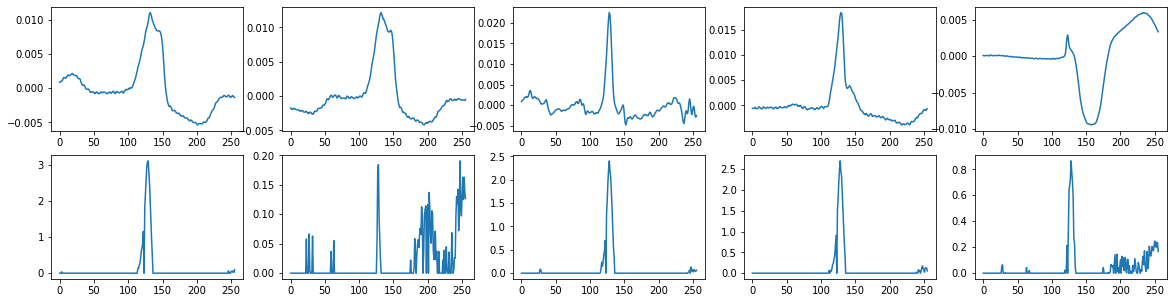

4 0.8743324875831604


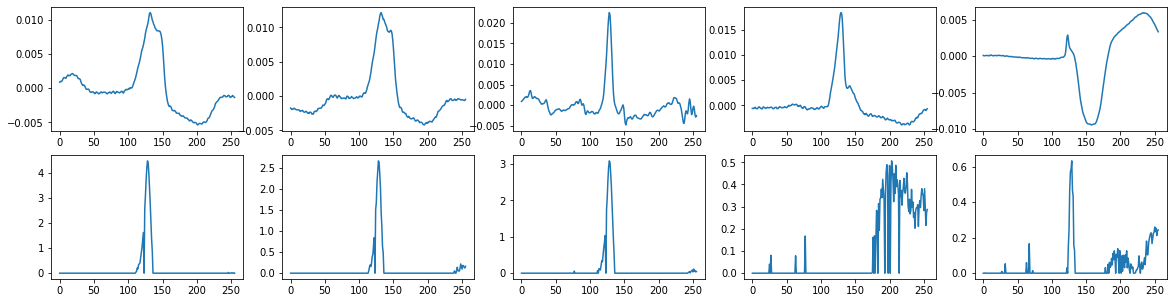

5 0.7869613170623779


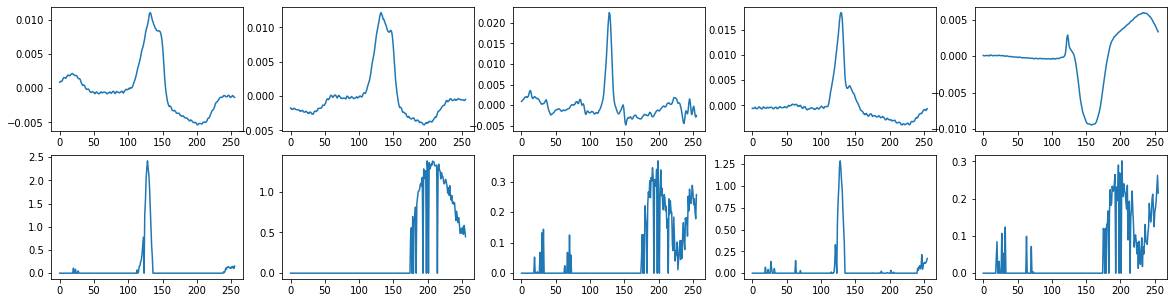

6 0.9076911807060242


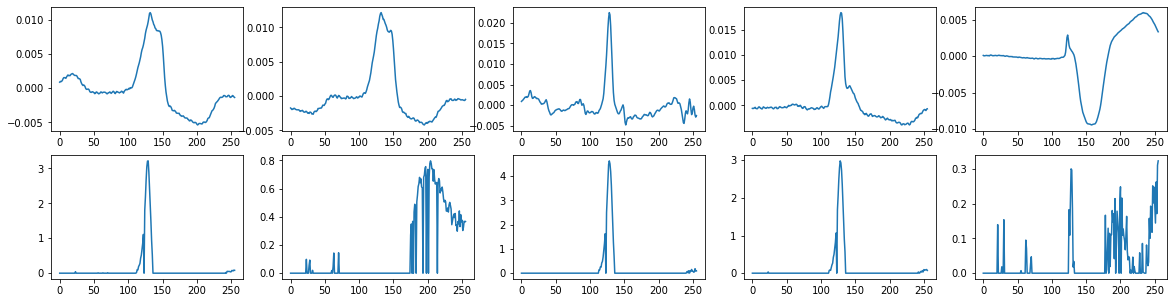

7 0.8844890594482422


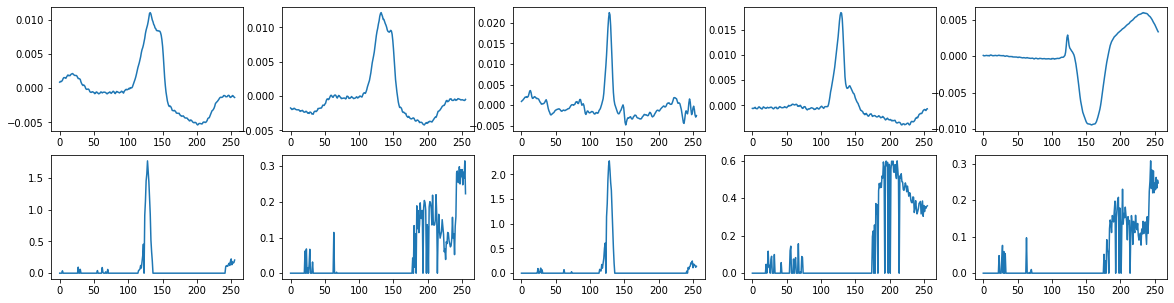

8 0.847530722618103


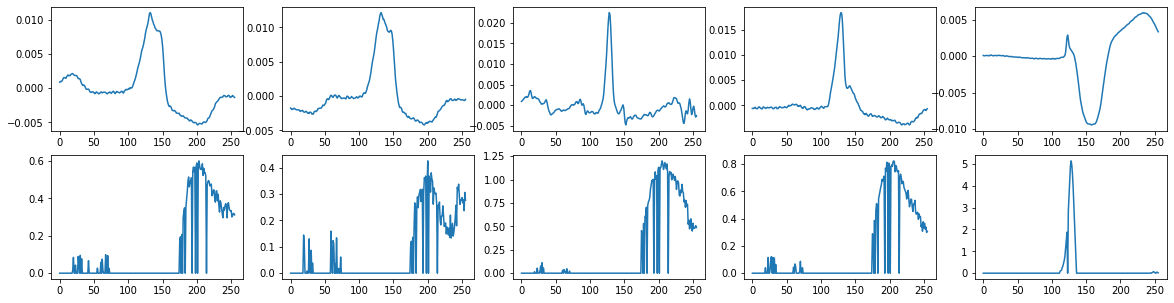

9 0.8008983135223389


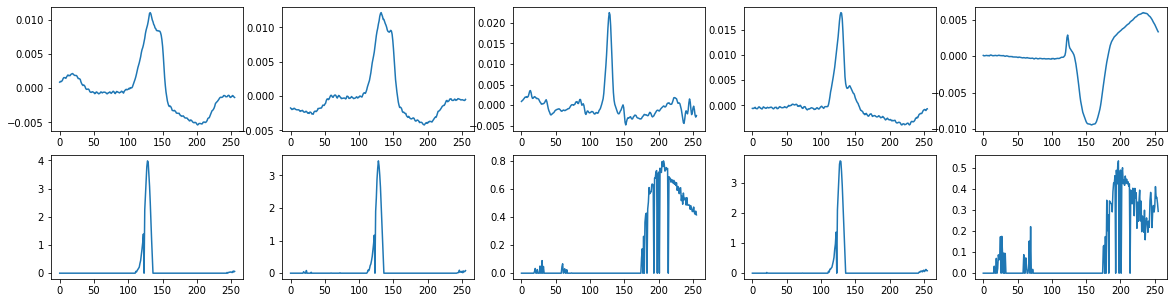

In [12]:
input_dim = 1 * 256
batch_size = 32


print('Number of samples: ', len(train_data))

encoder = Encoder(input_dim, 100, 100)
decoder = Decoder(8, 100, input_dim)
vae = VAE(encoder, decoder)

criterion = nn.MSELoss()

optimizer = optim.Adam(vae.parameters(), lr=0.0001)
l = None
for epoch in range(10):
    for i, data in enumerate(train_loader, 0):
        inputs, classes = data
        inputs, classes = Variable(inputs.resize_(batch_size, input_dim)).type(torch.FloatTensor), Variable(classes).type(torch.FloatTensor)
        optimizer.zero_grad()
        dec = vae(inputs)
        ll = latent_loss(vae.z_mean, vae.z_sigma)
        loss = criterion(dec, inputs) + ll
        loss.backward()
        optimizer.step()
        l = loss.item()
    print(epoch, l)
    vae_data = vae(view_data)
    f, a = plt.subplots(2, 5, figsize=(20,5))

    for i in range(5):
        a[0][i].plot(view_data.data.numpy()[i])

    for i in range(5):
        a[1][i].clear()
        a[1][i].plot(vae_data.data.numpy()[i])
    plt.show();
